In [1]:
import faiss
import numpy as np
import os
from collections import defaultdict

In [2]:
datasets = ["sharegpt", "wildchat", "wizardlm+sharegpt"]
datasets = ["wizardlm+sharegpt"]
embeddings_file = {
    "e5-large": 'e5-large-v2-tulu_user_only-embeddings.npy',
    'cohere': 'embed-english-v3.0-tulu_user_only-embeddings.npy',
    'llama': 'Llama-2-7b-hf-tulu_user_only-embeddings.npy',
}
Ks = [32, 64, 128, 256, 512, 1024, 2048, 4096]
embedding_path_template = "/mnt/data/data-selection/data/processed/{}/{}"

In [3]:
embeddings_dict = defaultdict(dict)
# load the embeddings
for dataset in datasets:
    for model, file in embeddings_file.items():
        path = embedding_path_template.format(dataset, file)
        if not os.path.exists(path):
            print(f"Embeddings not found at {path}")
            continue
        print(f"Loading {path}")
        embeddings = np.load(path)
        print(f"Loaded {embeddings.shape}")
        embeddings_dict[dataset][model] = embeddings
        # # build the index
        # index = faiss.IndexFlatL2(embeddings.shape[1])
        # index.add(embeddings)

Loading /mnt/data/data-selection/data/processed/wizardlm+sharegpt/e5-large-v2-tulu_user_only-embeddings.npy
Loaded (25704, 1024)
Loading /mnt/data/data-selection/data/processed/wizardlm+sharegpt/embed-english-v3.0-tulu_user_only-embeddings.npy
Loaded (25704, 1024)
Loading /mnt/data/data-selection/data/processed/wizardlm+sharegpt/Llama-2-7b-hf-tulu_user_only-embeddings.npy


Loaded (25704, 4096)


In [4]:
# calculation of sillhouette score
def silhouette_coefficient(cluster_index, samples) -> float:
    # At each data point, we calculate the distance to the cluster center in which the data point belongs (referred to as a),
    # as well as the distance to the second best cluster center (referred to as b). Here, the second best cluster refers
    # to the closest cluster that is not the current data point’s cluster. Then based, on these two distances a and b, the
    # silhouette s of that data point is calculated as s=(b-a)/max(a,b). The mean of all s is the s coefficient and measures
    # quality of the clustering for this nr of k
    #
    # This is done by simply calculating the silhouette coefficient over a range of k, and identifying the peak as the optimum K.
    distance, _ = cluster_index.search(samples, 2)
    
    # a = distance[:, 0], b = distance[:, 1]
    # s = (b - a) / np.max(a, b)
    s = (distance[:, 1] - distance[:, 0]) / np.max(distance, 1)

    # A score of 1 denotes the best, meaning that the data point i is very compact within the cluster to which it belongs
    # and far away from the other clusters. The worst value is -1. Values near 0 denote overlapping clusters.
    return s.mean()

In [6]:
# perform kmeans clustering with sharegpt, ks and models
# sharegpt_embeddings = embeddings_dict["sharegpt"]
sillhouette_scores = defaultdict(dict)
computed = {'e5-large': {64: 0.1135735,
                           256: 0.08558801,
                           512: 0.09684662,
                           2048: 0.1632899,
                           4096: 0.24751739},
                          'cohere': {64: 0.16065995,
                           256: 0.13459153,
                           512: 0.1010436,
                           2048: 0.16390704,
                           4096: 0.24233213},
                          'llama': {64: 0.232516,
                           256: 0.21015981,
                           512: 0.21620865,
                           2048: 0.26690328,
                           4096: 0.3434755}}
for key, value in computed.items():
    for k, v in value.items():
        sillhouette_scores["wizardlm+sharegpt"][key] = {k: v}

for name, name_embeddings in embeddings_dict.items():
    if name not in sillhouette_scores:
        sillhouette_scores[name] = defaultdict(dict)
    for model, embeddings in name_embeddings.items():
        embeddings = embeddings[~np.isnan(embeddings).any(axis=1)]
        embeddings = embeddings[~np.isinf(embeddings).any(axis=1)]
        for k in Ks:
            if k in sillhouette_scores[name][model]:
                continue
            print(f"Calculating sillhouette score for {model} with k={k}")
            index = faiss.IndexFlatL2(embeddings.shape[1])
            index.add(embeddings)

            # train k means
            kmeans = faiss.Kmeans(embeddings.shape[1], k, niter=300, verbose=True, gpu=True, nredo=2)
            kmeans.train(embeddings)

            sillhouette_scores[name][model][k] = silhouette_coefficient(kmeans.index, embeddings)
sillhouette_scores

Calculating sillhouette score for e5-large with k=32
Sampling a subset of 8192 / 25704 for training
Clustering 8192 points in 1024D to 32 clusters, redo 2 times, 300 iterations
  Preprocessing in 0.04 s
Outer iteration 0 / 2
  Iteration 299 (2.47 s, search 2.05 s): objective=0.154068 imbalance=1.980 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 2
  Iteration 299 (5.05 s, search 4.34 s): objective=0.153993 imbalance=2.239 nsplit=0       
Objective improved: keep new clusters
Calculating sillhouette score for e5-large with k=64
Sampling a subset of 16384 / 25704 for training
Clustering 16384 points in 1024D to 64 clusters, redo 2 times, 300 iterations
  Preprocessing in 0.05 s
Outer iteration 0 / 2
  Iteration 299 (5.90 s, search 4.53 s): objective=0.344954 imbalance=2.289 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 2
  Iteration 299 (11.19 s, search 8.95 s): objective=0.344957 imbalance=2.402 nsplit=0       
Calculating sillhouet

WARNING clustering 25704 points to 1024 centroids: please provide at least 39936 training points


  Iteration 299 (8.97 s, search 7.53 s): objective=0.471279 imbalance=2.167 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 2
  Iteration 299 (17.61 s, search 14.77 s): objective=0.466398 imbalance=2.189 nsplit=0       
Objective improved: keep new clusters
Calculating sillhouette score for e5-large with k=2048


WARNING clustering 25704 points to 2048 centroids: please provide at least 79872 training points


Clustering 25704 points in 1024D to 2048 clusters, redo 2 times, 300 iterations
  Preprocessing in 0.03 s
Outer iteration 0 / 2
  Iteration 299 (10.53 s, search 8.29 s): objective=0.363853 imbalance=2.815 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 2
  Iteration 299 (20.91 s, search 16.61 s): objective=0.441926 imbalance=2.810 nsplit=0       
Calculating sillhouette score for cohere with k=32
Sampling a subset of 8192 / 25704 for training
Clustering 8192 points in 1024D to 32 clusters, redo 2 times, 300 iterations
  Preprocessing in 0.03 s
Outer iteration 0 / 2
  Iteration 299 (2.84 s, search 2.29 s): objective=0.426636 imbalance=5.846 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 2
  Iteration 299 (5.54 s, search 4.61 s): objective=0.516599 imbalance=4.096 nsplit=0       
Calculating sillhouette score for cohere with k=64
Sampling a subset of 16384 / 25704 for training
Clustering 16384 points in 1024D to 64 clusters, redo 2 tim

WARNING clustering 25704 points to 1024 centroids: please provide at least 39936 training points


Clustering 25704 points in 1024D to 1024 clusters, redo 2 times, 300 iterations
  Preprocessing in 0.03 s
Outer iteration 0 / 2
  Iteration 299 (9.22 s, search 7.78 s): objective=1.82755 imbalance=4.775 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 2
  Iteration 299 (18.39 s, search 15.44 s): objective=1.82838 imbalance=4.832 nsplit=0       
Calculating sillhouette score for cohere with k=2048
Clustering 25704 points in 1024D to 2048 clusters, redo 2 times, 300 iterations
  Preprocessing in 0.03 s
Outer iteration 0 / 2


WARNING clustering 25704 points to 2048 centroids: please provide at least 79872 training points


  Iteration 299 (10.37 s, search 8.34 s): objective=1.24095 imbalance=4.298 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 2
  Iteration 299 (20.48 s, search 16.27 s): objective=1.24014 imbalance=4.224 nsplit=0       
Objective improved: keep new clusters
Calculating sillhouette score for llama with k=32
Sampling a subset of 8192 / 25704 for training
Clustering 8192 points in 4096D to 32 clusters, redo 2 times, 300 iterations
  Preprocessing in 0.16 s
Outer iteration 0 / 2
  Iteration 299 (9.01 s, search 8.26 s): objective=3.37632e+07 imbalance=1.189 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 2
  Iteration 299 (18.37 s, search 16.56 s): objective=3.37564e+07 imbalance=1.117 nsplit=0       
Objective improved: keep new clusters
Calculating sillhouette score for llama with k=64
Sampling a subset of 16384 / 25704 for training
Clustering 16384 points in 4096D to 64 clusters, redo 2 times, 300 iterations
  Preprocessing in 0.21 s
Out

WARNING clustering 25704 points to 1024 centroids: please provide at least 39936 training points


Clustering 25704 points in 4096D to 1024 clusters, redo 2 times, 300 iterations
  Preprocessing in 0.11 s
Outer iteration 0 / 2
  Iteration 299 (32.41 s, search 28.00 s): objective=6.75086e+07 imbalance=1.435 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 2
  Iteration 299 (64.41 s, search 55.65 s): objective=6.77875e+07 imbalance=1.425 nsplit=0       
Calculating sillhouette score for llama with k=2048


WARNING clustering 25704 points to 2048 centroids: please provide at least 79872 training points


Clustering 25704 points in 4096D to 2048 clusters, redo 2 times, 300 iterations
  Preprocessing in 0.11 s
Outer iteration 0 / 2
  Iteration 299 (37.79 s, search 30.21 s): objective=6.03779e+07 imbalance=1.614 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 2
  Iteration 299 (75.80 s, search 60.49 s): objective=6.04998e+07 imbalance=1.560 nsplit=0       


defaultdict(dict,
            {'wizardlm+sharegpt': {'e5-large': {4096: 0.24751739,
               32: 0.15187961,
               64: 0.1135735,
               128: 0.082464956,
               256: 0.08558801,
               512: 0.09684662,
               1024: 0.120416455,
               2048: 0.1632899},
              'cohere': {4096: 0.24233213,
               32: 0.22763245,
               64: 0.16065995,
               128: 0.15199853,
               256: 0.13459153,
               512: 0.1010436,
               1024: 0.12200588,
               2048: 0.16390704},
              'llama': {4096: 0.3434755,
               32: 0.24473196,
               64: 0.232516,
               128: 0.21952105,
               256: 0.21015981,
               512: 0.21620865,
               1024: 0.2302762,
               2048: 0.26690328}}})

/mnt/data/selection/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/mnt/data/selection/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/mnt/data/selection/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 1.0, 'Sillhouette scores for wizardlm+sharegpt dataset')

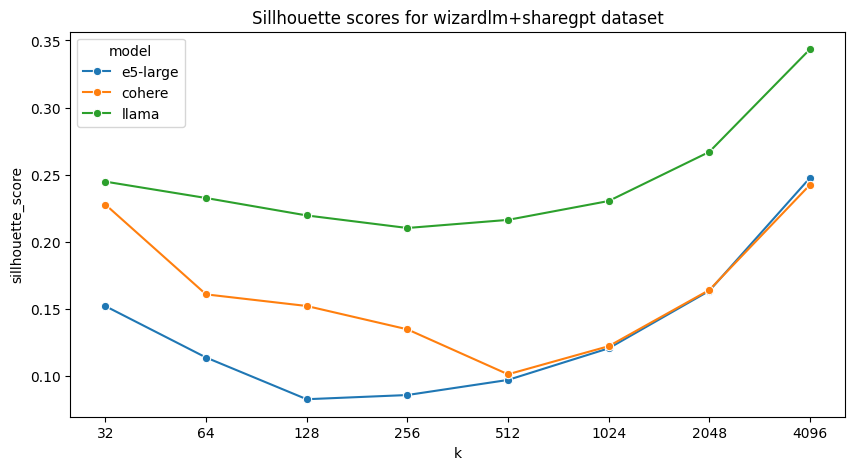

In [7]:
# plot the heatmap of sillhouette scores
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

name = "wizardlm+sharegpt"
sillhouette_scores_df = pd.DataFrame(sillhouette_scores[name])
sillhouette_scores_df = sillhouette_scores_df.reset_index()
# make the index as categorical
sillhouette_scores_df['k'] = sillhouette_scores_df['index'].astype('category')
# set the k as str
# sort by k
sillhouette_scores_df = sillhouette_scores_df.sort_values('k')
sillhouette_scores_df['k'] = sillhouette_scores_df['k'].astype(str)
# remove the index
sillhouette_scores_df = sillhouette_scores_df.drop(columns='index')

# take the mean between e5-large, cohere and llama
# sillhouette_scores_df['mean'] = sillhouette_scores_df.drop(columns='k').mean(axis=1)
# plot the mean sillhouette score
# fig, ax = plt.subplots(figsize=(10, 5))
# melted_df = sillhouette_scores_df.melt(id_vars='k', var_name='model', value_name='sillhouette_score')
# # only keep model == mean
# melted_df = melted_df[melted_df['model'] == 'mean']
# # orange line
# sns.lineplot(data=melted_df, x='k', y='sillhouette_score', marker='o', color='orange', ax=ax)
# plt.title(f"Sillhouette scores for {name} dataset")

# ax1 = ax.twinx()
# # plot the lora ft performance as bar chart
# lora_ft_performance_df = pd.DataFrame(lora_ft_performance, index=[0])
# lora_ft_performance_df = lora_ft_performance_df.melt(var_name='k', value_name='lora_ft_performance')
# lora_ft_performance_df['k'] = lora_ft_performance_df['k'].astype(str)
# sns.barplot(data=lora_ft_performance_df, x='k', y='lora_ft_performance', ax=ax1, color='blue', alpha=0.5)
# # set the ylim for ax1 to be [42, 44]
# ax1.set_ylim([42, 44])
# # add a dotted line horizontal line at 43.45 as the baseline
# ax1.axhline(43.45, color='red', linestyle='--', label='Random')
# ax1.legend(loc='upper right', bbox_to_anchor=(1.0, 1.2))
# # set the ax1 y label to be "Average Score"
# ax1.set_ylabel("Average Score")

# make the column of k as discrete
# sort the columns 
fig, ax = plt.subplots(figsize=(10, 5))
# sillhouette_scores_df = sillhouette_scores_df[sillhouette_scores_df.columns.sort_values()]
# # sns.heatmap(sillhouette_scores_df, annot=True)
# # draw line plot, with column 'k' as the x axis, and each column as a line
sns.lineplot(data=sillhouette_scores_df.melt(id_vars='k', var_name='model', value_name='sillhouette_score'), x='k', y='sillhouette_score', hue='model', marker='o')
# rename the x axis label to [""]
# # add title
plt.title(f"Sillhouette scores for {name} dataset")

In [10]:
tulu_v2_embedding = "/mnt/data/sparseIT/data/processed/tulu_v2/embed-english-v3.0-tulu_user_only-embeddings.npy"
tulu_v2_embedding = np.load(tulu_v2_embedding)

tulu_v2_sillhouette_score = {}
for k in Ks:
    print(f"Calculating sillhouette score for {model} with k={k}")
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)

    # train k means
    kmeans = faiss.Kmeans(embeddings.shape[1], k, niter=300, verbose=True, gpu=True, nredo=2)
    kmeans.train(embeddings)

    tulu_v2_sillhouette_score[k] = silhouette_coefficient(kmeans.index, embeddings)

Calculating sillhouette score for llama with k=64
Sampling a subset of 16384 / 25704 for training
Clustering 16384 points in 4096D to 64 clusters, redo 2 times, 300 iterations
  Preprocessing in 0.21 s
Outer iteration 0 / 2
  Iteration 299 (17.72 s, search 16.31 s): objective=6.13441e+07 imbalance=1.140 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 2
  Iteration 299 (35.20 s, search 32.48 s): objective=6.08733e+07 imbalance=1.202 nsplit=0       
Objective improved: keep new clusters
Calculating sillhouette score for llama with k=256
Clustering 25704 points in 4096D to 256 clusters, redo 2 times, 300 iterations
  Preprocessing in 0.11 s
Outer iteration 0 / 2
  Iteration 299 (28.30 s, search 25.81 s): objective=8.0824e+07 imbalance=1.207 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 2
  Iteration 299 (56.15 s, search 51.26 s): objective=8.08486e+07 imbalance=1.188 nsplit=0       
Calculating sillhouette score for llama with k=512
Cl

WARNING clustering 25704 points to 2048 centroids: please provide at least 79872 training points


Clustering 25704 points in 4096D to 2048 clusters, redo 2 times, 300 iterations
  Preprocessing in 0.11 s
Outer iteration 0 / 2
  Iteration 299 (38.25 s, search 30.81 s): objective=6.03779e+07 imbalance=1.614 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 2
  Iteration 299 (75.23 s, search 60.55 s): objective=6.04998e+07 imbalance=1.560 nsplit=0       
Calculating sillhouette score for llama with k=4096


WARNING clustering 25704 points to 4096 centroids: please provide at least 159744 training points


Clustering 25704 points in 4096D to 4096 clusters, redo 2 times, 300 iterations
  Preprocessing in 0.11 s
Outer iteration 0 / 2
  Iteration 299 (49.05 s, search 34.96 s): objective=5.11797e+07 imbalance=1.760 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 2
  Iteration 299 (99.47 s, search 70.79 s): objective=5.13421e+07 imbalance=1.727 nsplit=0       


<Axes: xlabel='k', ylabel='sillhouette_score'>

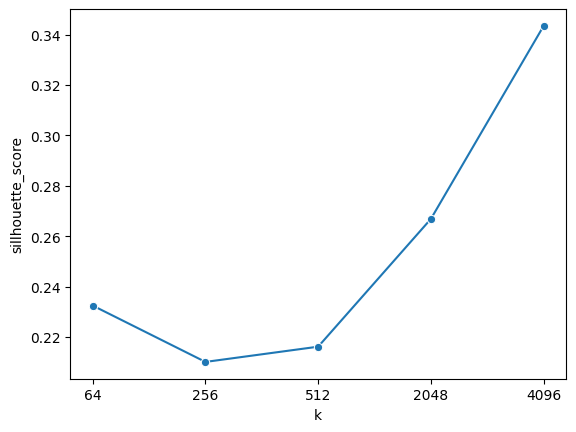

In [14]:
tulu_v2_sillhouette_score
# plot the line chart for tulu_v2
tulu_v2_sillhouette_score_df = pd.DataFrame(tulu_v2_sillhouette_score, index=[0])
tulu_v2_sillhouette_score_df = tulu_v2_sillhouette_score_df.melt(var_name='k', value_name='sillhouette_score')
tulu_v2_sillhouette_score_df['k'] = tulu_v2_sillhouette_score_df['k'].astype(str)
tulu_v2_sillhouette_score_df
sns.lineplot(data=tulu_v2_sillhouette_score_df, x='k', y='sillhouette_score', marker='o')

Clustering 25704 points in 4096D to 512 clusters, redo 3 times, 300 iterations
  Preprocessing in 0.11 s
Outer iteration 0 / 3
  Iteration 299 (29.17 s, search 26.08 s): objective=7.40882e+07 imbalance=1.309 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 3
  Iteration 299 (58.59 s, search 52.41 s): objective=7.40399e+07 imbalance=1.266 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 3
  Iteration 299 (87.73 s, search 78.43 s): objective=7.40018e+07 imbalance=1.285 nsplit=0       
Objective improved: keep new clusters


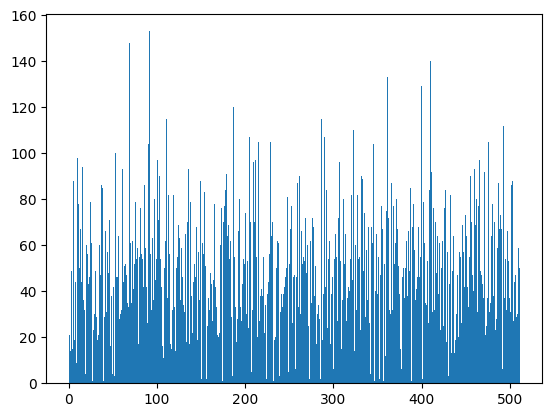

In [9]:
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

# take 512 and 4906 as the best k
# plot the kmeans clustering for k=512 and k=4096
# for k in [512, 4096]:
for k in [512]:
    kmeans = faiss.Kmeans(embeddings.shape[1], k=k, niter=300, verbose=True, gpu=True, nredo=3)
    kmeans.train(embeddings)

    # get the indices of the clusters
    _, indices = kmeans.index.search(embeddings, 1)
    # plot the number of datapoint assigned to each cluster
    plt.hist(indices, bins=k)


Counter({91: 153, 68: 148, 410: 140, 361: 133, 400: 129, 102: 125, 187: 120, 286: 115, 110: 115, 493: 112, 323: 110, 290: 107, 205: 107, 476: 105, 229: 105, 215: 105, 90: 104, 346: 104, 354: 102, 53: 100, 9: 98, 212: 97, 466: 97, 100: 97, 209: 96, 307: 96, 15: 94, 460: 93, 61: 93, 135: 93, 472: 92, 411: 92, 179: 91, 456: 90, 332: 90, 103: 90, 261: 90, 195: 89, 333: 89, 5: 88, 149: 88, 503: 88, 366: 87, 487: 87, 259: 87, 37: 86, 502: 86, 85: 86, 312: 85, 388: 85, 38: 85, 10: 84, 427: 84, 292: 84, 177: 84, 409: 84, 154: 83, 118: 82, 327: 82, 433: 82, 113: 82, 321: 82, 248: 81, 345: 81, 438: 81, 2: 81, 372: 80, 97: 80, 311: 80, 193: 80, 462: 80, 153: 79, 24: 79, 402: 79, 75: 79, 138: 79, 44: 78, 481: 78, 391: 78, 11: 78, 165: 78, 368: 77, 355: 77, 465: 77, 176: 77, 252: 77, 414: 76, 426: 76, 173: 76, 81: 76, 360: 75, 200: 74, 335: 74, 270: 73, 490: 73, 450: 73, 203: 72, 363: 72, 295: 72, 268: 72, 306: 72, 276: 72, 404: 71, 303: 71, 46: 71, 101: 71, 483: 70, 134: 70, 210: 70, 206: 70, 231:

(array([17.,  7.,  3.,  5.,  1.,  1.,  3.,  3.,  3.,  7.,  5.,  9.,  5.,
         7.,  4.,  6.,  6., 10.,  7., 18., 11., 13.,  6., 16.,  7., 13.,
        14.,  8., 10., 13., 16.,  8., 14.,  9., 17., 12., 16.,  2., 10.,
         8., 11.,  7., 10.,  7., 12.,  9., 10.,  3.,  3.,  4., 10., 10.,
         4.,  6.,  5.,  6.,  3.,  5.,  4.,  3.,  3.,  1.,  2.,  4.,  0.,
         1.,  1.,  2.,  3.,  2.,  0.,  1.,  0.,  1.,  0.,  2.,  0.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([  1.  ,   2.52,   4.04,   5.56,   7.08,   8.6 ,  10.12,  11.64,
         13.16,  14.68,  16.2 ,  17.72,  19.24,  20.76,  22.28,  23.8 ,
         25.32,  26.84,  28.36,  29.88,  31.4 ,  32.92,  34.44,  35.96,
         37.48,  39.  ,  40.52,  42.04,  43.56,  45.08,  46.6 ,  48.12,
         49.64,  51.16,  52.68,  54.2 ,  55.72,  57.24,  58.76,  60.28,
         61.8 ,  63.32,  64.84,  66.36,  67.88,  69.4 ,  70.92,  72.44,
  

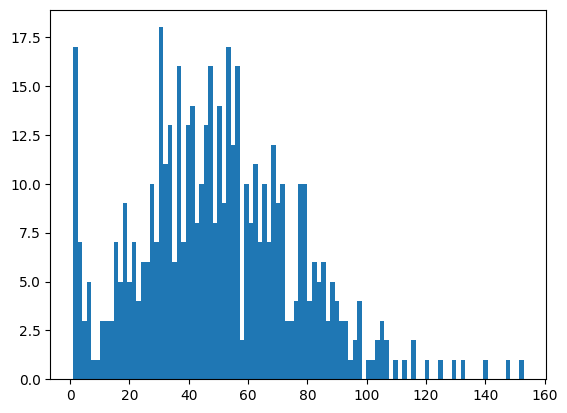

In [17]:
from collections import Counter
index2count = Counter(indices[:, 0])
# plot the distribution of the value of the counter
print(index2count)
plt.hist(index2count.values(), bins=100)